# Process and map range of trigger thresholds

In [2]:
import xarray as xr
from xarray.groupers import SeasonResampler
import xesmf as xe
import numpy as np
import pandas as pd 
import os
import glob
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import matplotlib as mpl
from cartopy import crs as ccrs
import cmocean
from dask.diagnostics import ProgressBar
from numba import jit as njit

from funcs_support import get_params,get_filepaths, utility_print
from funcs_aux import get_landmask

dir_list = get_params()

In [3]:
df = get_filepaths()
# df_tmp = df.query('experiment == "hindcasts" and run == "NMME"')
# df_tmp = df.query('model == "CHIRPS" and freq == "Amon"')

proc_source = 'NMME'

if proc_source == 'GPCP':
    #----- For GPCP ----- 
    df_tmp = df.query('model == "GPCP"')
    fn = df_tmp.iloc[0]['path']
    ds = xr.open_dataset(fn)
    
elif proc_source == 'CHIRPS':
    #----- For CHIRPS ----- 
    df_tmp = df.query('model == "GPCP"')
    fn = df_tmp.iloc[0]['path']
    ds = xr.open_dataset(fn,chunks = {'lat':20,'lon':20,'time':-1})

elif proc_source == 'NMME':
    #----- For NMME -----
    # Will require setting model explicilty in figure code
    df_tmp = df.query('exp == "hindcasts"')
    ds = xr.concat([xr.open_dataset(row[1]['path'],chunks={'lat':20,'lon':50})
                    for row in df_tmp.iterrows()],
                   dim=pd.Index([row[1]['model'] for row in df_tmp.iterrows()],
                                               name='model'),
                    join='outer')

In [122]:
xr.open_dataset(fn,chunks='auto').pr

<xarray.DataArray 'pr' (time: 561, lat: 72, lon: 144)> Size: 23MB
dask.array<open_dataset-pr, shape=(561, 72, 144), dtype=float32, chunksize=(561, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2025-09-01
  * lat      (lat) float32 288B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float32 576B -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
Attributes:
    long_name:     Average Monthly Rate of Precipitation
    valid_range:   [  0. 100.]
    units:         mm/day
    precision:     32767
    var_desc:      Precipitation
    dataset:       GPCP Version 2.3 Combined Precipitation Dataset
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Mean
    actual_range:  [0.000000e+00 1.365714e+13]

## Calculate trigger thresholds

In [3]:
# Trigger threshold
aa_trigger = 0.2

In [4]:
# Get seasonal means
dsm = ds.groupby(
    time=SeasonResampler(["DJF", "MAM", "JJA", "SON"], drop_incomplete=True)
).mean()

# Unstack into season x year
dsm['season'] = dsm.time.dt.season
dsm['year'] = dsm.time.dt.year
dsm = dsm.set_index(time=['season','year']).unstack()

with ProgressBar():
    dsm = dsm.compute()

[########################################] | 100% Completed | 32.83 s


In [5]:
rng = np.random.default_rng()
# How many years / block
samp_size = 5
# How many bootstrap draws
ndraws = 1000

# indices of starting years
start_years = xr.DataArray(rng.integers(0,dsm.sizes['year'] - samp_size,
                           (ndraws,np.ceil(dsm.sizes['year']/samp_size).astype(int))),
                           dims=['draw','block'])

In [6]:
@njit
def get_boot_threshs(da, start_years, aa_trigger=aa_trigger, samp_size=samp_size):
    ''' Numabized bootstrap thresholds '''
    
    # Make sure the input_core_dims order matches this
    n_run = start_years.shape[0]
    n_block = start_years.shape[1]

    threshs = np.empty(n_run, dtype=da.dtype)

    # For each bootstrap run, generate moving blocks
    for run_idx in range(n_run):
        # Preallocate draws: (blocks × samp_size)
        draws = np.empty((n_block, samp_size), dtype=da.dtype)

        for b in range(n_block):
            sy = start_years[run_idx, b]
            draws[b, :] = da[sy:sy + samp_size]

        threshs[run_idx] = np.quantile(draws, aa_trigger)

    return threshs

In [ ]:
with ProgressBar():
    # Get 20% trigger for each time series draw
    threshs =  xr.apply_ufunc(get_boot_threshs,
                               dsm.pr,
                               start_years,
                               input_core_dims = [['year'],['draw','block']],
                               output_core_dims = [['draw']],
                               vectorize=True,
                               dask = 'parallelized')
threshs = threshs.to_dataset(name='triggthresh')

# Get range of threshholds
threshs['triggiqr'] = threshs['triggthresh'].quantile(0.975,dim='draw') - threshs['triggthresh'].quantile(0.025,dim='draw')

# Get means for reference
threshs['threshmean'] = threshs['triggthresh'].mean('draw')
# would need new ufunc above threshs['prmean'] = draws.pr.mean('year').mean('draw')

# Get IQR / mean precipitation
threshs['triggiqr_cv_meanpr'] = (threshs['triggiqr'] / dsm.pr.mean('year'))

# IQR / mean trigger
threshs['triggiqr_cv'] = threshs['triggiqr'] / threshs['triggthresh'].mean('draw')
# And log version of the same
threshs['triggiqr_cv_log'] = np.log(threshs['triggiqr'])

## Plot figures

In [8]:
# Get landmask
landmask = get_landmask(threshs,lm_source='ne110')

lat/lon bounds not found in dataset; they will be created.


In [9]:
# Load seasonal thresholds
ds_seas = xr.open_zarr(dir_list['proc']+'CHIRPS/prseasstats_doyavg_CHIRPS_historical_obs_1981010101-20250930.zarr')

In [10]:
# One non-leap reference year (matches pandas/xarray season logic)
ts = xr.DataArray(
    pd.date_range('2001-01-01', '2001-12-31'),
    dims=['time'],
)

# dayofyear coordinate: 1..365
doy = ts.dt.dayofyear
season = ts.dt.season

def seasonal_fraction(onset, demise, season_doy_mask):
    """
    Fraction of climatological season covered by a rainy season.

    onset, demise : DataArray (DOY)
    season_doy_mask : DataArray(dayofyear) bool
    """
    season_days = doy.where(season_doy_mask, drop=True)
    n_season_days = season_days.size

    # Broadcast DOY to lat/lon grid
    doy_3d = season_days.broadcast_like(onset)

    # Non-wrapping rainy season
    normal = onset <= demise
    in_rainy_normal = (doy_3d >= onset) & (doy_3d <= demise)

    # Wrapping rainy season (e.g. Nov–Feb)
    in_rainy_wrap = (doy_3d >= onset) | (doy_3d <= demise)

    in_rainy = xr.where(normal, in_rainy_normal, in_rainy_wrap)

    # Count overlapping days
    overlap_days = in_rainy.sum('time')

    return overlap_days / n_season_days

    

out = []

seas_frac_thresh = 0.2

for s in ['DJF','MAM','JJA','SON']:
    season_mask = season == s

    frac = seasonal_fraction(
        onset=ds_seas.onset,
        demise=ds_seas.demise,
        season_doy_mask=season_mask,
    )

    # If either rainy season satisfies the threshold → True
    active = (frac >= seas_frac_thresh).any("season")

    active = active.assign_coords(season=s).expand_dims("season")
    out.append(active)

active_seasons = xr.concat(out, dim="season").compute()

In [13]:
rgrd = xe.Regridder(active_seasons,threshs,'conservative')
active_seasons_rg = rgrd(active_seasons)
active_seasons_rg = active_seasons_rg.sel(lat=threshs.lat.values)

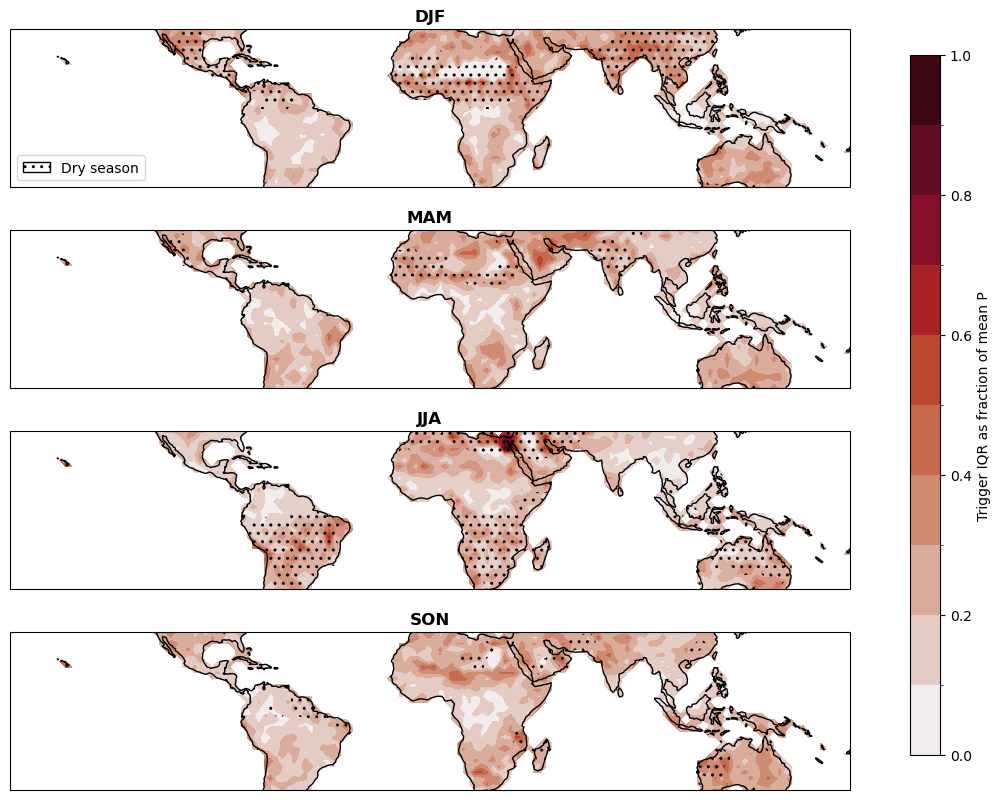

In [118]:
fig = plt.figure(figsize=(12,10))

var = 'triggiqr_cv_meanpr'

cbar_params = {'triggiqr':{'vmin':0,'vmax':5,'cmap':cmocean.cm.amp,'levels':11},
               'triggiqr_cv_log':{'vmin':-1,'vmax':1,'cmap':mpl.colormaps['berlin'],'levels':11},
               'triggiqr_cv_meanpr':{'vmin':0,'vmax':1,'cmap':cmocean.cm.amp,'levels':11}}

labels = {'triggiqr':'IQR of bootstrapped trigger thresholds [mm/day]',
          'triggiqr_cv_log':'IQR / Mean of bootstrapped trigger thresholds',
          'triggiqr_cv_meanpr':'Trigger IQR as fraction of mean P'}


subset_params = {'lat':slice(-35,35)}

for seas_idx,seas in enumerate(['DJF','MAM','JJA','SON']):
    ax = plt.subplot(4,1,seas_idx+1,projection=ccrs.PlateCarree())

    plot_data = threshs[var].sel(season=seas,**subset_params)
    # Subset to land only
    plot_data = plot_data.where(landmask)

    # Plot
    plot_data.plot.contourf(transform=ccrs.PlateCarree(),**cbar_params[var],
                            add_colorbar=False)

    # Grey out regions without an active rainy season
    active_seasons_rg.sel(season=seas,**subset_params).where(landmask).plot.contourf(levels=[-0.5, 0.5, 1.5],
                                                                                     colors=['none','none'],
                                                                                     hatches=["..", None],
                                                                                     transform=ccrs.PlateCarree(),
                                                                                     add_colorbar=False)

    ax.coastlines()
    ax.set_title(seas,fontweight='bold',fontsize=12)

    if seas_idx == 0:
        ax.legend(handles=[mpatches.Patch(facecolor='none',hatch='..',edgecolor='k',
                                          label='Dry season')],loc='lower left')

fig.subplots_adjust(right=0.825)
cax = fig.add_axes([0.875, 0.15, 0.025, 0.7])
levels = mpl.ticker.MaxNLocator(nbins=cbar_params[var]['levels']).tick_values(cbar_params[var]['vmin'],cbar_params[var]['vmax'])
norm = mpl.colors.BoundaryNorm(levels, ncolors=cbar_params[var]['cmap'].N, clip=True)
sm = plt.cm.ScalarMappable(cmap=cbar_params[var]['cmap'],norm=norm)
plt.colorbar(sm,cax=cax,label=labels[var])